In [3]:
import os 
import pandas as pd 
os.listdir('/kaggle/input') 
media_path = "/kaggle/input/media-coverage-speeches-unmerged"
speeches = pd.read_csv(f"{media_path}/full_data_updated_24.csv")
news = pd.read_csv(f"{media_path}/full_mediacoverage_preprocessed.csv")

In [4]:
print(speeches.columns)
print(speeches.head())
print(news.columns)
print(news.head())
print(speeches.shape)
print(news.shape)

Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date'], dtype='object')
   Unnamed: 0  X  speech_id  \
0           1  1          1   
1           2  2          2   
2           3  3          3   
3           4  4          4   
4           5  5          5   

                                               title  \
0  Versión estenográfica de la conferencia de pre...   
1  Versión estenográfica de la conferencia de pre...   
2  Versión estenográfica. Aniversario de la Huelg...   
3  Versión estenográfica. Programas para el Biene...   
4  Versión estenográfica. Programas para el Biene...   

                                                urls  \
0  https://lopezobrador.org.mx/2024/01/09/version...   
1  https://lopezobrador.org.mx/2024/01/08/version...   
2  https://lopezobrador.org.mx/2024/01/07/version...   
3  https://lopezobrador.org.mx/2024/01/06/version...   
4  https://lopezobrador.org.mx/2024/01/06/version...   

                                             co

### BERTopic by month macro and micro topics

In [5]:
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 25.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
# Convert the `date` and `Date` columns to datetime format
speeches['date'] = pd.to_datetime(speeches['date'])
news['Date'] = pd.to_datetime(news['Date'])

# Extract the year and month for both datasets
speeches['year_month'] = speeches['date'].dt.to_period('M')
news['year_month'] = news['Date'].dt.to_period('M')

# Show the updated dataframe with the extracted month and year
print(speeches[['speech_id', 'title', 'date', 'year_month']].head())
print(news[['Index', 'Title', 'Date', 'year_month']].head())


   speech_id                                              title       date  \
0          1  Versión estenográfica de la conferencia de pre... 2024-01-09   
1          2  Versión estenográfica de la conferencia de pre... 2024-01-08   
2          3  Versión estenográfica. Aniversario de la Huelg... 2024-01-07   
3          4  Versión estenográfica. Programas para el Biene... 2024-01-06   
4          5  Versión estenográfica. Programas para el Biene... 2024-01-06   

  year_month  
0    2024-01  
1    2024-01  
2    2024-01  
3    2024-01  
4    2024-01  
          Index                                              Title       Date  \
0  1_01_12_2018  Toma de protesta de AMLO: las 5 tradiciones qu... 2018-12-01   
1  2_01_12_2018        AMLO rinde protesta y promete no reelegirse 2018-12-01   
2  3_01_12_2018  ¿Hay Ley Seca este 1 de diciembre por cambio d... 2018-12-01   
3  4_01_12_2018  AMLO es un "líder persistente", dice la superc... 2018-12-01   
4  5_01_12_2018  Nicolás Maduro lleg

In [10]:
!pip install bertopic



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.6 MB/s eta 0:00:0000:0100:01


In [15]:
# Download NLTK stopwords
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
spanish_stopwords_nltk = set(stopwords.words('spanish'))

# Load Spanish stopwords and add custom ones
nlp = spacy.load("es_core_news_sm")
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso',
    'contenido relacionado', 'cd', 'mandamos correo', 'lunes', 'mandamos', 'correo', 'martes', 'miércoles',
    'viernes', 'sábado', 'sabado', 'domingo', 'contenido', 'necesita periodismo', 'señor', 'pregunta', '01',
    'importante', 'pueblo', 'libre', 'necesita', 'hrs', '13', '16', '990', 'cable', 'news', 'cable news',
    'network', 'copyright', 'multimedia', 'multimedios', '2024', '2025', '2023', '2022', '2021', '2020', '2019',
    '2018', 'association', 'publicado', 'dof', 'laiman', '000', 'discovery', 'company', 'amlo', 'gobierno nacional',
    'años', 'mandatario', 'país', 'pais', 'lã³pez', 'mintiã³', 'aã', 'paã', 'ciento', 'gente', 'margen'
]
# Combine NLTK stopwords with custom stopwords
all_stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)).union(spanish_stopwords_nltk))

def preprocess_text(text):
    words = text.lower().split()
    words = [re.sub(r'\W+', '', w) for w in words if w not in all_stopwords]
    return ' '.join(words)

# Apply to full speech/news datasets
speeches['clean_content'] = speeches['content'].apply(preprocess_text)
news['clean_content'] = news['Content'].apply(preprocess_text)

import numpy as np

def parse_embeddings(df, column_name):
    return np.vstack(
        df[column_name].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
    )

# Only needed if embeddings are available as strings
# speech_embeddings_np = parse_embeddings(speeches, 'speech_embeddings')
# news_embeddings_np = parse_embeddings(news, 'news_embeddings')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
import os
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import hdbscan
import joblib
import gzip
from sklearn.feature_extraction.text import CountVectorizer

# Initialize SentenceTransformer for embedding generation
embedding_model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es', device='cuda')

# Initialize vectorizer with custom stopwords
vectorizer_model = CountVectorizer(stop_words=all_stopwords, ngram_range=(1, 2), min_df=1)

def global_topic_modeling():
    # Combine all texts
    all_texts = speeches['clean_content'].tolist() + news['processed_content'].tolist()

    # Define UMAP and HDBSCAN
    umap_model = UMAP(n_neighbors=8, n_components=5, min_dist=0.05, metric="cosine", random_state=42)
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=25, prediction_data=True)

    # Create and fit BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        calculate_probabilities=True,
        low_memory=True
    )

    global_topics, _ = topic_model.fit_transform(all_texts)

    # Save UMAP, HDBSCAN, Vectorizer separately (optional)
    with gzip.open('global_topic_model.pkl.gz', 'wb') as f:
        joblib.dump({
            'umap_model': umap_model,
            'hdbscan_model': hdbscan_model,
            'vectorizer_model': vectorizer_model
        }, f)

    # Save speeches and news with topic labels
    speeches['global_topic'] = global_topics[:len(speeches)]
    news['global_topic'] = global_topics[len(speeches):]
    speeches.to_csv('speeches_with_global_topics.csv', index=False)
    news.to_csv('news_with_global_topics.csv', index=False)

    # Return fitted topic model so it can be used to extract topics or visualize
    return topic_model

# 🔁 Re-run global topic modeling and keep the returned model
topic_model = global_topic_modeling()

In [40]:
import pandas as pd

# Load the speeches and news with global topics
speeches = pd.read_csv('speeches_with_global_topics.csv')
news = pd.read_csv('news_with_global_topics.csv')

# Merge them into one dataframe for easier analysis (optional)
combined_df = pd.concat([speeches[['speech_id', 'date', 'global_topic', 'clean_content']],
                         news[['date', 'urls', 'global_topic', 'processed_content']].rename(columns={'urls': 'url', 'processed_content': 'content'})], 
                        ignore_index=True)

# Example: Analyze the frequency of each global topic over time
topic_over_time = combined_df.groupby(['date', 'global_topic']).size().reset_index(name='count')

# Plot or visualize the change in topic frequency over time to see how topics evolve after speeches
import matplotlib.pyplot as plt

topic_over_time_pivot = topic_over_time.pivot_table(index='date', columns='global_topic', values='count', fill_value=0)
topic_over_time_pivot.plot(kind='line', figsize=(12, 6))
plt.title('Topic Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Topic Frequency')
plt.show()


KeyError: "['date', 'urls'] not in index"

In [28]:
import os
import pandas as pd
from bertopic import BERTopic
from tqdm import tqdm

# Function to perform micro topic modeling for each month
def micro_topic_modeling():
    all_results = []

    # Loop over each unique year_month combination
    for year_month in tqdm(pd.concat([speeches['year_month'], news['year_month']]).unique(), desc="Processing months"):
        print(f"Processing month: {year_month}")

        # Filter speeches and news by the current month
        speeches_month = speeches[speeches['year_month'] == year_month]
        news_month = news[news['year_month'] == year_month]

        # Combine the text from speeches and news for the month
        all_texts = speeches_month['clean_content'].tolist() + news_month['processed_content'].tolist()

        # Load the global topic model (previously saved)
        with gzip.open('global_topic_model.pkl.gz', 'rb') as f:
            topic_model_data = joblib.load(f)
            umap_model = topic_model_data['umap_model']
            hdbscan_model = topic_model_data['hdbscan_model']
            vectorizer_model = topic_model_data['vectorizer_model']

        # Perform topic modeling for micro topics (this uses the same model)
        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            calculate_probabilities=True,
            low_memory=True
        )

        # Fit the micro topics for the current month
        micro_topics, _ = topic_model.fit_transform(all_texts)

        # Assign micro topics to speeches and news
        speeches_month['micro_topic'] = micro_topics[:len(speeches_month)]
        news_month['micro_topic'] = micro_topics[len(speeches_month):]

        # Save the results for the month
        speeches_month['year_month'] = year_month
        news_month['year_month'] = year_month

        # Combine the processed data
        all_data = pd.concat([speeches_month, news_month], ignore_index=True)

        # Save the processed data for this month
        month_file = f'micro_topics_{year_month}.csv'
        all_data.to_csv(month_file, index=False)

        all_results.append(all_data)


In [29]:
import pandas as pd
from bertopic import BERTopic
import gzip
import joblib

# Ensure 'date' column is present and formatted
speeches['date'] = pd.to_datetime(speeches['date'])
news['Date'] = pd.to_datetime(news['Date'])

# Combine all texts for topic modeling (speeches + news)
all_texts = speeches['clean_content'].tolist() + news['processed_content'].tolist()

# Load the saved model components
with gzip.open("global_topic_model.pkl.gz", "rb") as f:
    model_parts = joblib.load(f)

# Create the BERTopic object using saved components
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=model_parts["umap_model"],
    hdbscan_model=model_parts["hdbscan_model"],
    vectorizer_model=model_parts["vectorizer_model"],
    calculate_probabilities=True,
    low_memory=True,
)

# Fit the model again on the combined text data
topic_model.fit(all_texts)

# Get topic descriptions
topic_info = topic_model.get_topic_info()

# Save topic descriptions to CSV
topic_info.to_csv("macro_topics_summary.csv", index=False)

# If you want to visualize or extract further details about the topics, you can proceed here:
# For example, extracting the topics with their words:
# topics = topic_model.get_topics()


In [31]:
print(topic_info.head(5))

   Topic  Count                                Name  \
0     -1   7542            -1_amlo_mã_2025_gobierno   
1      0   1950   0_entonces_bueno_pregunta_jóvenes   
2      1    222    1_centavos_litro_precio_entonces   
3      2    206  2_informaciã³n_lã_narrativa_lã der   
4      3    188   3_vacunas_vacunación_dosis_vacuna   

                                      Representation  \
0  [amlo, mã, 2025, gobierno, mexicano, polã, 01,...   
1  [entonces, bueno, pregunta, jóvenes, interlocu...   
2  [centavos, litro, precio, entonces, gas, tren,...   
3  [informaciã³n, lã, narrativa, lã der, der, dat...   
4  [vacunas, vacunación, dosis, vacuna, salud, en...   

                                 Representative_Docs  
0  [actual director general aeropuerto internacio...  
1  [2022 ricardo flores magón precursor revolució...  
2  [2023 francisco villa revolucionario obrador d...  
3  [revista proceso derechos reservados   2025   ...  
4  [2021 independencia obrador días martes siempr...  


### Experiments 

In [ ]:
import nltk
import spacy
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
spanish_stopwords_nltk = set(stopwords.words('spanish'))

# Load SpaCy Spanish stopwords
nlp = spacy.load("es_core_news_sm")
spanish_stopwords_spacy = nlp.Defaults.stop_words

# Add your own custom stopwords
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso', 'contenido relacionado',
    'cd', 'mandamos correo', 'lunes', 'mandamos', 'correo', 'martes', 'miércoles', 'viernes', 'sábado', 'sabado', 'domingo',
    'necesita periodismo', 'señor', 'pregunta', '01', 'importante', 'pueblo', 'libre', 'necesita', 'hrs', '13', '16', '990',
    'cable', 'news', 'cable news', 'network', 'copyright', 'multimedia', 'multimedios', '2024', '2025', '2023', '2022', 
    '2021', '2020', '2019', '2018', 'association', 'publicado', 'dof', 'laiman', '000', 'discovery', 'company', 'amlo',
    'gobierno nacional', 'años','getty' 'mandatario', 'país', 'pais', 'lã³pez', 'mintiã³', 'aã', 'paã','ciento','gente','margen'
]

# Merge all into a single set
all_stopwords = spanish_stopwords_nltk.union(spanish_stopwords_spacy).union(set(custom_stop_words))

In [ ]:
def preprocess_text(text):
    words = text.lower().split()
    words = [re.sub(r'\W+', '', w) for w in words if w not in all_stopwords]
    return ' '.join(words)

# Apply to full speech/news datasets
speeches['clean_content'] = speeches['content'].apply(preprocess_text)
news['clean_content'] = news['Content'].apply(preprocess_text)

import numpy as np

def parse_embeddings(df, column_name):
    return np.vstack(
        df[column_name].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
    )

# Only needed if embeddings are available as strings
# speech_embeddings_np = parse_embeddings(speeches, 'speech_embeddings')
# news_embeddings_np = parse_embeddings(news, 'news_embeddings')


In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(
    '/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es',
    device='cuda'  # Use GPU
)


In [ ]:
!pip install bertopic


In [ ]:
pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com


In [ ]:
import os
os.environ["NUMBA_NUM_THREADS"] = "4"  # or 8 depending on your machine


In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
import pandas as pd
from sentence_transformers import SentenceTransformer
import spacy
import torch
import joblib
import os
from tqdm import tqdm
from time import time

# ✅ Load model using GPU
embedding_model = SentenceTransformer(
    '/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# 🧾 Combine data
speech_texts = speeches["clean_content"].tolist()
news_texts = news["processed_content"].tolist()
all_texts = speech_texts + news_texts

# ⚡ Generate/load embeddings
EMB_PATH = "cached_spanish_embeddings.pkl"
if os.path.exists(EMB_PATH):
    embeddings = joblib.load(EMB_PATH)
else:
    embeddings = embedding_model.encode(all_texts, show_progress_bar=True, device='cuda')
    joblib.dump(embeddings, EMB_PATH)

# 🛑 Stopwords
nlp = spacy.load("es_core_news_sm")
custom_stop_words = [...]
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

# 📊 CountVectorizer
vectorizer_model = CountVectorizer(stop_words=stopwords, ngram_range=(1, 2), min_df=2)

# 🚀 Fewer parameter sets
param_grid = [
    (20, 15),
    (50, 30),
    (100, 10),
]

results = []

print("\n🔍 Starting optimized grid search...\n")
for min_cluster_size, n_neighbors in tqdm(param_grid, desc="Grid Search", total=len(param_grid)):
    start_time = time()

    umap_model = UMAP(n_components=3, n_neighbors=n_neighbors, metric='cosine')  # 🔻 Reduce n_components
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)

    topic_model = BERTopic(
        embedding_model=None,  # use precomputed embeddings
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        calculate_probabilities=True,
        low_memory=True
    )

    topics, _ = topic_model.fit_transform(all_texts, embeddings)
    num_outliers = topics.count(-1)
    num_topics = len(set(topics)) - (1 if -1 in topics else 0)
    duration = round(time() - start_time, 2)

    results.append({
        "min_cluster_size": min_cluster_size,
        "n_neighbors": n_neighbors,
        "num_topics": num_topics,
        "num_outliers": num_outliers,
        "time_seconds": duration
    })
    print(f"✅ Done: min_cluster_size={min_cluster_size}, n_neighbors={n_neighbors} → {num_topics} topics in {duration}s")

# 🧾 Final results
results_df = pd.DataFrame(results).sort_values(by="num_outliers")
print("\n📊 Grid search results (sorted):")
print(results_df)


In [ ]:
param_grid = [
    (10, 5),
    (10, 8),
    (10, 10),
    (12, 5),
    (12, 8),
    (12, 10),
    (15, 5),
    (15, 8),
    (15, 10)
]
from tqdm import tqdm
from time import time
import pandas as pd

results_fine = []

print("\n⚡ FAST Grid Search: Minimizing Outliers ⚡\n")

for min_cluster_size, n_neighbors in tqdm(param_grid, desc="Grid Search"):
    start_time = time()

    umap_model = UMAP(n_components=2, n_neighbors=n_neighbors, metric='cosine', random_state=42)
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)

    topic_model = BERTopic(
        embedding_model=None,  # reuse precomputed GPU embeddings
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        calculate_probabilities=False,  # skip to save time
        low_memory=True,
        verbose=False
    )

    topics, _ = topic_model.fit_transform(all_texts, embeddings)
    num_outliers = topics.count(-1)
    num_topics = len(set(topics)) - (1 if -1 in topics else 0)
    duration = round(time() - start_time, 2)

    results_fine.append({
        "min_cluster_size": min_cluster_size,
        "n_neighbors": n_neighbors,
        "num_topics": num_topics,
        "num_outliers": num_outliers,
        "time_seconds": duration
    })

    print(f"✅ min_cluster_size={min_cluster_size}, n_neighbors={n_neighbors} → "
          f"{num_topics} topics, {num_outliers} outliers, {duration}s")

# 📊 Show best result
results_fine_df = pd.DataFrame(results_fine).sort_values(by="num_outliers")
print("\n🏁 Best Configurations (sorted by fewest outliers):")
print(results_fine_df)


# Chosen BERTOPIC model 

In [35]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
import pandas as pd
from sentence_transformers import SentenceTransformer
import spacy
import torch
import joblib
import os
from tqdm import tqdm
from time import time

# ✅ Load model using GPU
embedding_model = SentenceTransformer(
    '/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# 🧾 Combine data
speech_texts = speeches["clean_content"].tolist()
news_texts = news["processed_content"].tolist()
all_texts = speech_texts + news_texts

# ⚡ Generate/load embeddings
EMB_PATH = "cached_spanish_embeddings.pkl"
if os.path.exists(EMB_PATH):
    embeddings = joblib.load(EMB_PATH)
else:
    embeddings = embedding_model.encode(all_texts, show_progress_bar=True, device='cuda')
    joblib.dump(embeddings, EMB_PATH)

# 🛑 Stopwords
nlp = spacy.load("es_core_news_sm")
custom_stop_words = [...]
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

# 📊 CountVectorizer
vectorizer_model = CountVectorizer(stop_words=stopwords, ngram_range=(1, 2), min_df=2)

Batches:   0%|          | 0/1217 [00:00<?, ?it/s]

In [36]:
from tqdm import tqdm
from time import time
import pandas as pd

param_grid = [
    (8, 3), (8, 4), (8, 6),
    (9, 3), (9, 4), (9, 6),
    (11, 3), (11, 4), (11, 6),
    (20, 3), (20, 5), (20, 8),
    (25, 3), (25, 5), (25, 8)
]

results_refined = []

print("\n⚡ REFINED Grid Search: Exploring sweet spot between granularity and compactness\n")

for min_cluster_size, n_neighbors in tqdm(param_grid, desc="Grid Search"):
    start_time = time()

    umap_model = UMAP(n_components=2, n_neighbors=n_neighbors, metric='cosine', random_state=42)
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)

    topic_model = BERTopic(
        embedding_model=None,  # Reuse precomputed GPU embeddings
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        calculate_probabilities=False,
        low_memory=True,
        verbose=False
    )

    topics, _ = topic_model.fit_transform(all_texts, embeddings)
    num_outliers = topics.count(-1)
    num_topics = len(set(topics)) - (1 if -1 in topics else 0)
    duration = round(time() - start_time, 2)

    results_refined.append({
        "min_cluster_size": min_cluster_size,
        "n_neighbors": n_neighbors,
        "num_topics": num_topics,
        "num_outliers": num_outliers,
        "time_seconds": duration
    })

    print(f"✅ min_cluster_size={min_cluster_size}, n_neighbors={n_neighbors} → "
          f"{num_topics} topics, {num_outliers} outliers, {duration}s")

results_refined_df = pd.DataFrame(results_refined).sort_values(by="num_outliers")
print("\n🏁 Best Configurations (Refined Search, sorted by fewest outliers):")
print(results_refined_df)



⚡ REFINED Grid Search: Exploring sweet spot between granularity and compactness



Grid Search:   7%|▋         | 1/15 [03:03<42:49, 183.53s/it]

✅ min_cluster_size=8, n_neighbors=3 → 1826 topics, 6939 outliers, 183.53s


Grid Search:  13%|█▎        | 2/15 [06:02<39:12, 180.97s/it]

✅ min_cluster_size=8, n_neighbors=4 → 1812 topics, 6578 outliers, 179.18s


Grid Search:  20%|██        | 3/15 [08:15<31:46, 158.84s/it]

✅ min_cluster_size=8, n_neighbors=6 → 1682 topics, 3115 outliers, 132.49s


Grid Search:  27%|██▋       | 4/15 [11:12<30:29, 166.31s/it]

✅ min_cluster_size=9, n_neighbors=3 → 1679 topics, 7697 outliers, 177.77s


Grid Search:  33%|███▎      | 5/15 [14:11<28:28, 170.88s/it]

✅ min_cluster_size=9, n_neighbors=4 → 1678 topics, 6969 outliers, 178.97s


Grid Search:  40%|████      | 6/15 [16:24<23:40, 157.88s/it]

✅ min_cluster_size=9, n_neighbors=6 → 1578 topics, 3242 outliers, 132.64s


Grid Search:  47%|████▋     | 7/15 [19:20<21:50, 163.86s/it]

✅ min_cluster_size=11, n_neighbors=3 → 1332 topics, 9158 outliers, 176.18s


Grid Search:  53%|█████▎    | 8/15 [22:18<19:37, 168.23s/it]

✅ min_cluster_size=11, n_neighbors=4 → 1329 topics, 8767 outliers, 177.58s


Grid Search:  60%|██████    | 9/15 [24:30<15:41, 156.87s/it]

✅ min_cluster_size=11, n_neighbors=6 → 1343 topics, 2999 outliers, 131.9s


Grid Search:  67%|██████▋   | 10/15 [27:09<13:08, 157.74s/it]

✅ min_cluster_size=20, n_neighbors=3 → 480 topics, 17673 outliers, 159.67s


Grid Search:  73%|███████▎  | 11/15 [29:09<09:44, 146.01s/it]

✅ min_cluster_size=20, n_neighbors=5 → 793 topics, 5849 outliers, 119.41s


Grid Search:  80%|████████  | 12/15 [31:20<07:04, 141.59s/it]

✅ min_cluster_size=20, n_neighbors=8 → 762 topics, 5898 outliers, 131.48s


Grid Search:  87%|████████▋ | 13/15 [33:59<04:53, 146.64s/it]

✅ min_cluster_size=25, n_neighbors=3 → 308 topics, 20682 outliers, 158.26s


Grid Search:  93%|█████████▎| 14/15 [35:53<02:16, 136.94s/it]

✅ min_cluster_size=25, n_neighbors=5 → 626 topics, 8054 outliers, 114.52s


Grid Search: 100%|██████████| 15/15 [38:03<00:00, 152.26s/it]

✅ min_cluster_size=25, n_neighbors=8 → 605 topics, 7387 outliers, 130.22s

🏁 Best Configurations (Refined Search, sorted by fewest outliers):
    min_cluster_size  n_neighbors  num_topics  num_outliers  time_seconds
8                 11            6        1343          2999        131.90
2                  8            6        1682          3115        132.49
5                  9            6        1578          3242        132.64
10                20            5         793          5849        119.41
11                20            8         762          5898        131.48
1                  8            4        1812          6578        179.18
0                  8            3        1826          6939        183.53
4                  9            4        1678          6969        178.97
14                25            8         605          7387        130.22
3                  9            3        1679          7697        177.77
13                25            5         62

In [37]:
### FINAL BERTOPIC MODEL 

from umap import UMAP
import hdbscan
from bertopic import BERTopic

# Use optimized parameters
umap_model = UMAP(n_neighbors=6, n_components=2, metric="cosine", random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=11, prediction_data=True)

final_topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=False,
    low_memory=True,
    verbose=True
)

topics, _ = final_topic_model.fit_transform(all_texts, embeddings)
topic_labels = final_topic_model.generate_topic_labels()


2025-04-07 17:37:21,915 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-07 17:37:58,297 - BERTopic - Dimensionality - Completed ✓
2025-04-07 17:37:58,299 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-07 17:38:00,152 - BERTopic - Cluster - Completed ✓
2025-04-07 17:38:00,169 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-07 17:38:50,970 - BERTopic - Representation - Completed ✓


In [39]:
print(speeches.columns)
print(speeches.head(2))
print(news.columns)
print(news.head(2))
#So actually the global topics helped a lot then.  

Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'year_month', 'clean_content', 'global_topic'],
      dtype='object')
   Unnamed: 0  X  speech_id  \
0           1  1          1   
1           2  2          2   

                                               title  \
0  Versión estenográfica de la conferencia de pre...   
1  Versión estenográfica de la conferencia de pre...   

                                                urls  \
0  https://lopezobrador.org.mx/2024/01/09/version...   
1  https://lopezobrador.org.mx/2024/01/08/version...   

                                             content       date year_month  \
0  2024: Año de Felipe Carrillo Puerto, benemérit... 2024-01-09    2024-01   
1  2024: Año de Felipe Carrillo Puerto, benemérit... 2024-01-08    2024-01   

                                       clean_content  global_topic  
0  2024 felipe carrillo puerto benemérito proleta...            42  
1  2024 felipe carrillo puerto benemérito p

In [41]:
# BUT WE WILL LABEL IT SEPARATELY 
# Merge them into one dataframe for easier analysis (optional)
combined_df = pd.concat([
    speeches[['speech_id', 'date', 'global_topic', 'clean_content', 'urls']].rename(columns={'urls': 'url'}),
    news[['Date', 'Link', 'global_topic', 'processed_content']].rename(columns={'Date': 'date', 'Link': 'url', 'processed_content': 'content'})
], ignore_index=True)


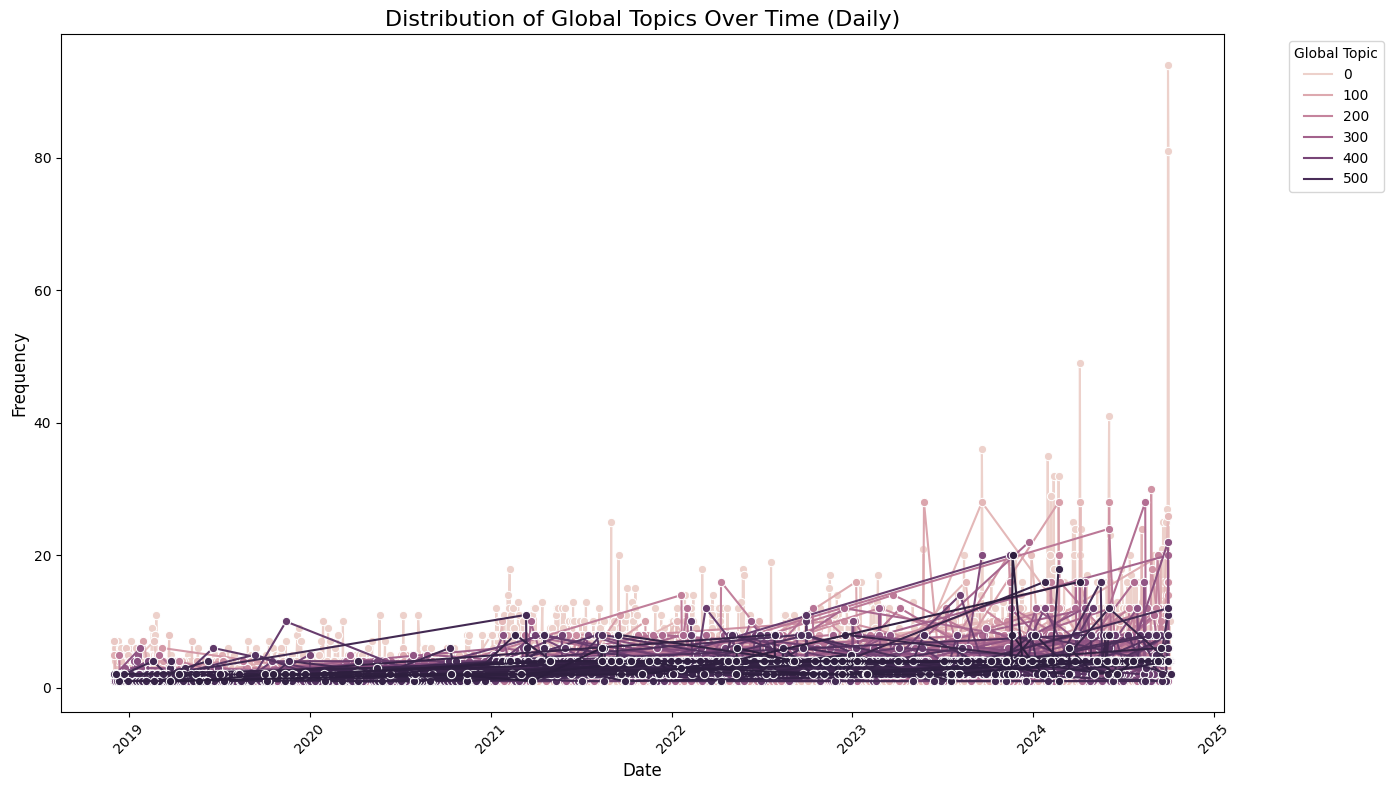

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'date' column is in datetime format
combined_df['date'] = pd.to_datetime(combined_df['date'], format='%Y-%m-%d')

# Count occurrences of each topic per date
topic_distribution_over_date = combined_df.groupby(['date', 'global_topic']).size().reset_index(name='count')

# Plot the distribution of topics over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=topic_distribution_over_date, x='date', y='count', hue='global_topic', marker='o')

# Adding titles and labels
plt.title('Distribution of Global Topics Over Time (Daily)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Global Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


In [46]:
# Get the top words for Topic 0
top_words_topic_0 = topic_model.get_topic(0)
print("Top words for Topic 0:", top_words_topic_0)


Top words for Topic 0: [('pregunta', 0.0028540856740405947), ('interlocutora', 0.002558358761622758), ('interlocutor', 0.0025375869919496545), ('qu', 0.0023718930653202587), ('ayer', 0.0019861435393800637), ('tema', 0.0019293073022423992), ('das', 0.0018765278202505231), ('informacin', 0.0017837016858831681), ('cmo', 0.0017542831705769017), ('gracias', 0.0017357196412122202)]


# More experiments 

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from collections import defaultdict

# Load and prepare data
speech_texts = speeches["clean_content"].tolist()
news_texts = news["processed_content"].tolist()
all_texts = speech_texts + news_texts

# Load Spanish stopwords and add custom ones
nlp = spacy.load("es_core_news_sm")
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso',
    'contenido relacionado', 'cd', 'mandamos correo', 'lunes', 'mandamos', 'correo', 'martes', 'miércoles',
    'viernes', 'sábado', 'sabado', 'domingo', 'contenido', 'necesita periodismo', 'señor', 'pregunta', '01',
    'importante', 'pueblo', 'libre', 'necesita', 'hrs', '13', '16', '990', 'cable', 'news', 'cable news',
    'network', 'copyright', 'multimedia', 'multimedios', '2024', '2025', '2023', '2022', '2021', '2020', '2019',
    '2018', 'association', 'publicado', 'dof', 'laiman', '000', 'discovery', 'company', 'amlo', 'gobierno nacional',
    'años', 'mandatario', 'país', 'pais', 'lã³pez', 'mintiã³', 'aã', 'paã', 'ciento', 'gente', 'margen'
]
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

# Vectorizer
vectorizer_model = CountVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=1
)

# Load embedding model (Spanish Sentence-BERT)
embedding_model = SentenceTransformer(
    '/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es',
    device='cuda'
)

# 🧠 Stage 1: MACRO Topics
print("📦 Generating MACRO Topics...")

umap_macro = UMAP(n_neighbors=8, n_components=5, min_dist=0.05, metric="cosine", random_state=42)
hdbscan_macro = hdbscan.HDBSCAN(min_cluster_size=25, prediction_data=True)

macro_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_macro,
    hdbscan_model=hdbscan_macro,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    low_memory=True
)

macro_topics, _ = macro_model.fit_transform(all_texts)
unique_macro_topics = sorted(set(macro_topics) - {-1})  # Exclude outliers

# 🔍 Stage 2: MICRO Topics
print("🔍 Generating MICRO Topics inside each MACRO Topic...")

macro2micro = defaultdict(dict)

for macro_topic in tqdm(unique_macro_topics, desc="Micro-clustering"):
    indices = [i for i, t in enumerate(macro_topics) if t == macro_topic]
    sub_texts = [all_texts[i] for i in indices]

    # Precompute embeddings
    sub_embeddings = embedding_model.encode(sub_texts, device="cuda", show_progress_bar=False)

    # Micro-topic modeling (fine-grained)
    umap_micro = UMAP(n_neighbors=6, n_components=5, min_dist=0.05, metric="cosine", random_state=42)
    hdbscan_micro = hdbscan.HDBSCAN(min_cluster_size=6, prediction_data=True)

    micro_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_micro,
        hdbscan_model=hdbscan_micro,
        vectorizer_model=vectorizer_model,
        calculate_probabilities=True,
        low_memory=True
    )

    micro_topics, _ = micro_model.fit_transform(sub_texts, sub_embeddings)

    # Store the micro-model and results
    macro2micro[macro_topic]["micro_model"] = micro_model
    macro2micro[macro_topic]["micro_topics"] = micro_topics
    macro2micro[macro_topic]["texts"] = sub_texts

print("✅ Done! Macro and micro topics are stored in `macro_model` and `macro2micro`.")


In [18]:
import pandas as pd
import os
import gzip
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import hdbscan
import joblib
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

# Download NLTK stopwords
nltk.download('stopwords')

# Define stopwords (custom + NLTK)
spanish_stopwords_nltk = set(stopwords.words('spanish'))
custom_stop_words = ['presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso', ...]
all_stopwords = list(spanish_stopwords_nltk.union(set(custom_stop_words)))

# Preprocess function
def preprocess_text(text):
    words = text.lower().split()
    words = [re.sub(r'\W+', '', w) for w in words if w not in all_stopwords]
    return ' '.join(words)

# Initialize SentenceTransformer for embedding generation
embedding_model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es', device='cuda')

# Initialize vectorizer model with custom stopwords
vectorizer_model = CountVectorizer(stop_words=all_stopwords, ngram_range=(1, 2), min_df=1)

# Define directory for saving results
save_dir = "./monthly_topic_modeling_results/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Store results in a dictionary
monthly_topic_results = defaultdict(dict)

# Create the global dataset for topic modeling (combining all speeches and news)
all_texts = speeches['clean_content'].tolist() + news['processed_content'].tolist()

# Perform **global topic modeling** (macro-level)
umap_model = UMAP(n_neighbors=8, n_components=5, min_dist=0.05, metric="cosine", random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=25, prediction_data=True)

# Perform global topic modeling
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    low_memory=True
)

# Fit the global topic model to the combined dataset
global_topics, _ = topic_model.fit_transform(all_texts)

# Save the global topic model (macro topics)
topic_model_file = os.path.join(save_dir, "global_topic_model.pkl.gz")
with gzip.open(topic_model_file, "wb") as f:
    joblib.dump({
        'umap_model': umap_model,
        'hdbscan_model': hdbscan_model,
        'vectorizer_model': vectorizer_model
    }, f)

# Assign global topics to all speeches and news articles
speeches['global_topic'] = global_topics[:len(speeches)]
news['global_topic'] = global_topics[len(speeches):]

# Now for **micro-level topics** per document (can also track changes over time)

# Initialize the vectorizer again, but this time assign topics at the document level
for year_month in tqdm(pd.concat([speeches['year_month'], news['year_month']]).unique(), desc="Processing months"):
    print(f"\nProcessing month: {year_month}")
    
    # Filter speeches and news by month
    speeches_month = speeches[speeches['year_month'] == year_month]
    news_month = news[news['year_month'] == year_month]
    
    # Combine speeches and news for micro-level topic modeling
    all_texts = speeches_month['clean_content'].tolist() + news_month['processed_content'].tolist()

    # Perform micro topic modeling using the same global model (macro-level) to assign topics
    micro_topics, _ = topic_model.transform(all_texts)

    # Assign micro topics to the dataframes
    speeches_month["micro_topic"] = micro_topics[:len(speeches_month)]
    news_month["micro_topic"] = micro_topics[len(speeches_month):]

    # Assign the month to track time evolution
    speeches_month["year_month"] = year_month
    news_month["year_month"] = year_month

    # Combine the processed data back into a final dataframe
    all_data = pd.concat([speeches_month, news_month], ignore_index=True)

    # Save combined data with macro and micro topics
    combined_file = os.path.join(save_dir, f"combined_data_{year_month}.csv.gz")
    all_data.to_csv(combined_file, index=False, compression='gzip')

    print(f"Processed topics for {year_month}")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [ ]:
#### SAving datafrom macro and micro topics 

In [ ]:
import pandas as pd

# Step 1: Macro model summary
macro_topic_info = macro_model.get_topic_info()
macro_topic_info = macro_topic_info[macro_topic_info.Topic != -1]

macro_summary = {
    "Model Type": "Macro",
    "Num Topics": len(macro_topic_info),
    "Avg Docs per Topic": round(macro_topic_info["Count"].mean(), 2),
    "Min Docs per Topic": macro_topic_info["Count"].min(),
    "Max Docs per Topic": macro_topic_info["Count"].max(),
    "Outliers": sum(1 for t in macro_topics if t == -1)
}

# Step 2: Micro topics summary (across all subclusters)
micro_topic_counts = []
micro_outliers = 0

for topic_id, data in macro2micro.items():
    micro_topics = data["micro_topics"]
    valid_topics = [t for t in micro_topics if t != -1]

    if len(valid_topics) == 0:
        continue

    topic_count = pd.Series(valid_topics).value_counts()
    micro_topic_counts.extend(topic_count.tolist())
    micro_outliers += sum(1 for t in micro_topics if t == -1)

micro_summary = {
    "Model Type": "Micro",
    "Num Topics": len(micro_topic_counts),
    "Avg Docs per Topic": round(sum(micro_topic_counts) / len(micro_topic_counts), 2),
    "Min Docs per Topic": min(micro_topic_counts),
    "Max Docs per Topic": max(micro_topic_counts),
    "Outliers": micro_outliers
}

# Combine into table
comparison_df = pd.DataFrame([macro_summary, micro_summary])
print("📊 Macro vs Micro Topic Comparison:\n")
print(comparison_df.to_markdown(index=False))


In [ ]:
from tqdm import tqdm
import numpy as np

# 🧠 Extracting topic probabilities (macro and micro) into DataFrames
print("📊 Extracting probabilities for macro and micro topics...")

# Step 1: Macro Topic Probabilities
macro_topics, macro_probs = macro_model.transform(all_texts)
macro_probs_df = pd.DataFrame(macro_probs, columns=[f"Macro_Topic_{i}" for i in range(macro_probs.shape[1])])

# Step 2: Micro Topic Probabilities
micro_probs_full = [None] * len(all_texts)  # Placeholder for every doc's micro-topic probs

for macro_topic in tqdm(unique_macro_topics, desc="Extracting Micro Probabilities"):
    indices = [i for i, t in enumerate(macro_topics) if t == macro_topic]
    sub_texts = [all_texts[i] for i in indices]

    try:
        micro_model = macro2micro[macro_topic]["micro_model"]
        micro_probs = micro_model.transform(sub_texts)[1]

        # Fill back into full list in the right positions
        for idx, prob in zip(indices, micro_probs):
            micro_probs_full[idx] = prob
    except Exception as e:
        print(f"⚠️ Skipping topic {macro_topic} due to error: {e}")
        continue

# Replace None with zeros if some docs were not assigned any micro topics
max_micro_topics = max([p.shape[0] if p is not None else 0 for p in micro_probs_full])
micro_probs_array = np.array([
    p if p is not None else np.zeros(max_micro_topics) for p in micro_probs_full
])
micro_probs_df = pd.DataFrame(micro_probs_array, columns=[f"Micro_Topic_{i}" for i in range(micro_probs_array.shape[1])])

# Step 3: Merge Macro + Micro Probabilities
topic_probs_df = pd.concat([macro_probs_df, micro_probs_df], axis=1)

# Step 4: Split back into speech and news sets
speeches_with_topics = pd.concat([speeches.reset_index(drop=True), topic_probs_df.iloc[:len(speeches)].reset_index(drop=True)], axis=1)
news_with_topics = pd.concat([news.reset_index(drop=True), topic_probs_df.iloc[len(speeches):].reset_index(drop=True)], axis=1)

# Step 5: Save
speeches_with_topics.to_csv(f"{media_path}/speeches_with_topics.csv", index=False)
news_with_topics.to_csv(f"{media_path}/news_with_topics.csv", index=False)

print("✅ Done! Probabilities for macro and micro topics saved to your files.")


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

# 📊 Recompute topic probabilities from existing models
print("📤 Extracting topic probabilities (macro + micro)...")

# 1️⃣ Macro topic probabilities
macro_topic_probs = macro_model.transform(all_texts)[1]  # Already trained model

# 2️⃣ Micro topic probabilities
micro_probs_full = []
for macro_topic in tqdm(sorted(macro2micro.keys()), desc="Extracting Micro Topic Probabilities"):
    micro_model = macro2micro[macro_topic]["micro_model"]
    texts = macro2micro[macro_topic]["texts"]
    
    if len(texts) == 0:
        continue
    
    _, probs = micro_model.transform(texts)
    micro_probs_full.extend(probs)

# 3️⃣ Create DataFrames
macro_probs_df = pd.DataFrame(macro_topic_probs, columns=[f"Macro_Topic_{i}" for i in range(macro_topic_probs.shape[1])])
micro_probs_df = pd.DataFrame(micro_probs_full, columns=[f"Micro_Topic_{i}" for i in range(micro_probs_full[0].shape[0])])

# 4️⃣ Final DataFrame
topic_probs_df = pd.concat([macro_probs_df, micro_probs_df], axis=1)

# 5️⃣ Split back into speeches and news
speeches_with_topics = pd.concat([speeches.reset_index(drop=True), topic_probs_df.iloc[:len(speeches)].reset_index(drop=True)], axis=1)
news_with_topics = pd.concat([news.reset_index(drop=True), topic_probs_df.iloc[len(speeches):].reset_index(drop=True)], axis=1)

# 💾 Save only final results
output_path = "/kaggle/working"

speeches_with_topics.to_csv(f"{output_path}/speeches_with_topics.csv", index=False)
news_with_topics.to_csv(f"{output_path}/news_with_topics.csv", index=False)

with open(f"{output_path}/topic_probs_df.pkl", "wb") as f:
    pickle.dump(topic_probs_df, f)

print("✅ Probabilities extracted and saved to /kaggle/working/")


In [ ]:
import os 
os.listdir('/kaggle/input') 
topic_path= '/kaggle/input/topic-models'
files = os.listdir(topic_path)
print("files in topic-models:")
for file in files: 
    print("-", file)


In [ ]:
import pickle 
import pandas as pd 
# Set the path to your saved models
topic_models_path = "/kaggle/input/topic-models"

# Load the macro BERTopic model
with open(f"{topic_models_path}/macro_model.pkl", "rb") as f:
    macro_model = pickle.load(f)

# Load the macro2micro dictionary
with open(f"{topic_models_path}/macro2micro.pkl", "rb") as f:
    macro2micro = pickle.load(f)

# Load the combined macro + micro topic probabilities DataFrame
#with open(f"{topic_models_path}/topic_probs_df.pkl", "rb") as f:
 #   topic_probs_df = pickle.load(f)

print("✅ Models and topic probabilities successfully loaded!")


In [ ]:
macro_topic_info = macro_model.get_topic_info()
macro_topic_info.head()


In [ ]:
# Loop through each macro-topic and explore the corresponding micro-topics
for macro_id, data in macro2micro.items():
    micro_model = data["micro_model"]
    micro_topic_info = micro_model.get_topic_info()
    num_micro_topics = len(micro_topic_info[micro_topic_info["Topic"] != -1])

    print(f"\n🔹 Macro Topic {macro_id} has {num_micro_topics} micro-topics")

    for topic_id in micro_topic_info["Topic"]:
        if topic_id == -1:
            continue  # skip outlier topic
        keywords = micro_model.get_topic(topic_id)
        top_words = ", ".join([word for word, _ in keywords[:5]])
        print(f"    Micro Topic {topic_id}: {top_words}")



In [ ]:
print(speeches.columns)
print(news.columns)

In [ ]:
# 🔁 Reconstruct the macro topic assignments (if not saved earlier)
# macro_topics = macro_model.topics_  # if available, or passed from earlier

# 🗂️ Prepare a DataFrame to hold all text + topic info
doc_df = pd.DataFrame({
    "text": speeches["clean_content"].tolist() + news["processed_content"].tolist(),
    "source": ["speech"] * len(speeches) + ["news"] * len(news),
    "macro_topic": macro_model.topics_
})

# 🧩 Add micro topic per document by reconstructing the mapping
micro_topic_assignments = [None] * len(doc_df)

for macro_id, data in macro2micro.items():
    micro_topics = data["micro_topics"]
    macro_indices = [i for i, t in enumerate(macro_model.topics_) if t == macro_id]

    if len(micro_topics) != len(macro_indices):
        print(f"⚠️ Mismatch for Macro {macro_id}: {len(micro_topics)} micro topics vs {len(macro_indices)} indices")
        continue

    for i, global_idx in enumerate(macro_indices):
        micro_topic_assignments[global_idx] = micro_topics[i]

doc_df["micro_topic"] = micro_topic_assignments


In [ ]:
print(doc_df.head())

In [ ]:
# Merge the topic labels back into the speeches and news DataFrames
speeches_with_topics = speeches.copy()
speeches_with_topics["macro_topic"] = doc_df.loc[doc_df["source"] == "speech", "macro_topic"].values
speeches_with_topics["micro_topic"] = doc_df.loc[doc_df["source"] == "speech", "micro_topic"].values
speeches_with_topics["macro_keywords"] = doc_df.loc[doc_df["source"] == "speech", "macro_keywords"].values
speeches_with_topics["micro_keywords"] = doc_df.loc[doc_df["source"] == "speech", "micro_keywords"].values

news_with_topics = news.copy()
news_with_topics["macro_topic"] = doc_df.loc[doc_df["source"] == "news", "macro_topic"].values
news_with_topics["micro_topic"] = doc_df.loc[doc_df["source"] == "news", "micro_topic"].values
news_with_topics["macro_keywords"] = doc_df.loc[doc_df["source"] == "news", "macro_keywords"].values
news_with_topics["micro_keywords"] = doc_df.loc[doc_df["source"] == "news", "micro_keywords"].values


## Corrected code macro-micro topics preserving key information


In [ ]:
# Check the columns of the speeches and news DataFrames
print(speeches.columns)
print(news.columns)


In [ ]:
# Function to get top words for a topic
def get_top_words_for_topic(model, topic, n_top_words=10):
    try:
        words = model.get_topic(topic)
        if words:  # Check if the topic has associated words
            return [word for word, _ in words[:n_top_words]]
        else:
            print(f"Warning: No words found for topic {topic}")
            return []  # Return an empty list if no words are found
    except Exception as e:
        print(f"Error while getting top words for topic {topic}: {e}")
        return []  # Return an empty list in case of an error


# Initialize dictionaries to store the top words for each macro and micro topic
top_macro_keywords = {}
top_micro_keywords = {}

# Flag to print only the first result
printed_first = False

# Extract top words for each macro topic
for macro_topic, data in macro2micro.items():
    if not printed_first:  # Only print the first result
        print(f"Processing Macro Topic: {macro_topic}")
        
        # Ensure we have the necessary keys
        if 'micro_topics' in data and 'micro_model' in data:
            # Extract the micro topics for the current macro topic
            micro_topics = data["micro_topics"]
            print(f"Micro Topics for Macro {macro_topic}: {set(micro_topics)}")
            
            # Extract top words for each micro topic (excluding -1 which is an outlier)
            for micro_topic in set(micro_topics) - {-1}:  # Exclude outliers (-1)
                # Ensure micro_model is available and get the top words for the current micro topic
                micro_model = data["micro_model"]
                top_words = get_top_words_for_topic(micro_model, micro_topic)
                top_micro_keywords[micro_topic] = top_words
                print(f"Top words for Micro Topic {micro_topic}: {top_words}")
            
            # Extract top words for the current macro topic
            top_words_macro = get_top_words_for_topic(data["micro_model"], macro_topic)
            top_macro_keywords[macro_topic] = top_words_macro
            print(f"Top words for Macro Topic {macro_topic}: {top_words_macro}")
        
        printed_first = True
        break  # Exit after printing the first result

# Now we have the top words for each macro and micro topic (only the first one printed)


In [ ]:
# Generate topics for speeches and news with original metadata

# For speeches, keep the speech_id, date, and urls columns, and merge topic labels
speeches_with_meta = speeches[['speech_id', 'date', 'urls', 'clean_content']].copy()
speeches_with_meta["macro_topic"] = doc_df.loc[doc_df["source"] == "speech", "macro_topic"].values
speeches_with_meta["micro_topic"] = doc_df.loc[doc_df["source"] == "speech", "micro_topic"].values

# For news, keep the Index, Date, Link, and processed_content columns, and merge topic labels
news_with_meta = news[['Index', 'Date', 'Link', 'processed_content']].copy()
news_with_meta["macro_topic"] = doc_df.loc[doc_df["source"] == "news", "macro_topic"].values
news_with_meta["micro_topic"] = doc_df.loc[doc_df["source"] == "news", "micro_topic"].values

# Check the first few rows of the DataFrames to ensure everything is correct
print(speeches_with_meta.head())
print(news_with_meta.head())


In [ ]:
# Inspect the structure of 'macro2micro' to see how the models are stored
print(macro2micro.keys())  # Check the structure of the dictionary
print(macro2micro[0])      # Inspect a specific entry to check its structure

# Adjust the iteration code based on the correct structure of 'macro2micro'

# Assuming 'macro2micro' contains models directly associated with the topics
# Add new columns to both speeches_with_meta and news_with_meta
speeches_with_meta['macro_keywords'] = None
speeches_with_meta['micro_keywords'] = None
news_with_meta['macro_keywords'] = None
news_with_meta['micro_keywords'] = None

# Iterate through speeches to assign macro and micro topic keywords
for idx, row in speeches_with_meta.iterrows():
    macro_topic = row['macro_topic']
    micro_topic = row['micro_topic']
    
    # Get top keywords for macro topic
    if macro_topic in macro2micro:
        model = macro2micro[macro_topic]  # Directly access the model for the macro topic
        top_words_macro = get_top_words_for_topic(model, macro_topic)
        speeches_with_meta.at[idx, 'macro_keywords'] = top_words_macro
    else:
        speeches_with_meta.at[idx, 'macro_keywords'] = 'Model not found'
    
    # Extract top words for the micro topic
    if micro_topic != -1 and micro_topic in macro2micro[macro_topic]:  # Ensure micro model exists
        micro_model = macro2micro[macro_topic][micro_topic]  # Access the micro model for the specific micro_topic
        top_words_micro = get_top_words_for_topic(micro_model, micro_topic)
        speeches_with_meta.at[idx, 'micro_keywords'] = top_words_micro
    else:
        speeches_with_meta.at[idx, 'micro_keywords'] = 'Micro model not found'

# Iterate through news to assign macro and micro topic keywords
for idx, row in news_with_meta.iterrows():
    macro_topic = row['macro_topic']
    micro_topic = row['micro_topic']
    
    # Get top keywords for macro topic
    if macro_topic in macro2micro:
        model = macro2micro[macro_topic]
        top_words_macro = get_top_words_for_topic(model, macro_topic)
        news_with_meta.at[idx, 'macro_keywords'] = top_words_macro
    else:
        news_with_meta.at[idx, 'macro_keywords'] = 'Model not found'
    
    # Extract top words for the micro topic
    if micro_topic != -1 and micro_topic in macro2micro[macro_topic]:
        micro_model = macro2micro[macro_topic][micro_topic]
        top_words_micro = get_top_words_for_topic(micro_model, micro_topic)
        news_with_meta.at[idx, 'micro_keywords'] = top_words_micro
    else:
        news_with_meta.at[idx, 'micro_keywords'] = 'Micro model not found'

# Check the results to ensure the keywords are assigned
print(speeches_with_meta.head())
print(news_with_meta.head())


In [ ]:
# Assuming you already have a function like 'get_top_words_for_topic' defined previously

# Add new columns to both speeches_with_meta and news_with_meta
speeches_with_meta['macro_keywords'] = None
speeches_with_meta['micro_keywords'] = None
news_with_meta['macro_keywords'] = None
news_with_meta['micro_keywords'] = None

# Iterate through speeches to assign macro and micro topic keywords
for idx, row in speeches_with_meta.iterrows():
    macro_topic = row['macro_topic']
    micro_topic = row['micro_topic']
    
    # Get top keywords for macro topic
    top_words_macro = get_top_words_for_topic(macro2micro[macro_topic]["micro_model"], macro_topic)
    speeches_with_meta.at[idx, 'macro_keywords'] = top_words_macro
    
    # Extract top words for the micro topic
    if micro_topic != -1:  # Ignore outliers (if any)
        top_words_micro = get_top_words_for_topic(macro2micro[macro_topic]["micro_model"], micro_topic)
        speeches_with_meta.at[idx, 'micro_keywords'] = top_words_micro

# Iterate through news to assign macro and micro topic keywords
for idx, row in news_with_meta.iterrows():
    macro_topic = row['macro_topic']
    micro_topic = row['micro_topic']
    
    # Get top keywords for macro topic
    top_words_macro = get_top_words_for_topic(macro2micro[macro_topic]["micro_model"], macro_topic)
    news_with_meta.at[idx, 'macro_keywords'] = top_words_macro
    
    # Extract top words for the micro topic
    if micro_topic != -1:  # Ignore outliers (if any)
        top_words_micro = get_top_words_for_topic(macro2micro[macro_topic]["micro_model"], micro_topic)
        news_with_meta.at[idx, 'micro_keywords'] = top_words_micro

# Check the results to ensure the keywords are assigned
print(speeches_with_meta.head())
print(news_with_meta.head())


In [53]:
# Function to safely retrieve top words from the model
def get_top_words_safe(model, topic, n_top_words=10):
    try:
        if hasattr(model, 'get_topic'):
            words = model.get_topic(topic)
            if words:  # Ensure words are returned
                return [word for word, _ in words[:n_top_words]]
        return []  # Return empty if model is not valid or no words
    except Exception as e:
        return []

# Iterate through speeches and assign keywords for macro and micro topics
for idx, row in speeches_with_meta.iterrows():
    macro_topic = row['macro_topic']
    micro_topic = row['micro_topic']
    
    # For macro topic, retrieve top words
    if macro_topic in macro2micro:
        model = macro2micro[macro_topic]
        
        if isinstance(model, dict):  # Check if model is a dictionary for micro topics
            if micro_topic in model:
                micro_model = model[micro_topic]
                top_words_macro = get_top_words_safe(micro_model, macro_topic)
            else:
                top_words_macro = []  # Empty if no micro topic found
        else:
            top_words_macro = get_top_words_safe(model, macro_topic)
        
        speeches_with_meta.at[idx, 'macro_keywords'] = top_words_macro
    else:
        speeches_with_meta.at[idx, 'macro_keywords'] = []

    # For micro topic, retrieve top words if micro model exists
    if micro_topic != -1 and micro_topic in macro2micro.get(macro_topic, {}):
        micro_model = macro2micro[macro_topic].get(micro_topic)
        top_words_micro = get_top_words_safe(micro_model, micro_topic)
        speeches_with_meta.at[idx, 'micro_keywords'] = top_words_micro
    else:
        speeches_with_meta.at[idx, 'micro_keywords'] = []

# Print only the first row to confirm if everything is working
print(speeches_with_meta.head(1))


   speech_id        date                                               urls  \
0          1  2024-01-09  https://lopezobrador.org.mx/2024/01/09/version...   

                                       clean_content  macro_topic  \
0  2024 felipe carrillo puerto benemérito proleta...           46   

   micro_topic macro_keywords micro_keywords  
0         -1.0             []             []  


### Simple Bertopic experimentation

In [ ]:

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan

# Combine SpaCy + your custom stopwords
import spacy
nlp = spacy.load("es_core_news_sm")
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso', 'contenido relacionado',
    'cd', 'mandamos correo', 'lunes', 'mandamos', 'correo', 'martes', 'miércoles', 'viernes', 'sábado', 'sabado', 'domingo',
    'necesita periodismo', 'señor', 'pregunta', '01', 'importante', 'pueblo', 'libre', 'necesita', 'hrs', '13', '16', '990',
    'cable', 'news', 'cable news', 'network', 'copyright', 'multimedia', 'multimedios', '2024', '2025', '2023', '2022', 
    '2021', '2020', '2019', '2018', 'association', 'publicado', 'dof', 'laiman', '000', 'discovery', 'company', 'amlo',
    'gobierno nacional', 'años','getty' 'mandatario', 'país', 'pais', 'lã³pez', 'mintiã³', 'aã', 'paã','ciento','gente','margen'
]
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

vectorizer_model = CountVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=1
)

umap_model = UMAP(n_components=3, n_neighbors=100, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=50, metric='euclidean', prediction_data=True)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    nr_topics=100,
    low_memory=False, #We can add probabilities of topic p document
    calculate_probabilities = True
)


In [ ]:
speech_texts = speeches["clean_content"].tolist()
news_texts = news["processed_content"].tolist()

# Combine speech and news texts
all_texts = speech_texts + news_texts

# Fit the model on all texts (speeches and news)
all_topics, _ = topic_model.fit_transform(all_texts)

# Split the topics back into speeches and news
speech_topics = all_topics[:len(speech_texts)]
news_topics = all_topics[len(speech_texts):]

# Add the topic results back to the DataFrames
speeches["topic"] = speech_topics
news["topic"] = news_topics


In [ ]:
# Get the topics and their frequencies in speeches
speech_topic_freq = topic_model.get_topic_info()
print(speech_topic_freq.head())

# Get the topics and their frequencies in news articles
news_topic_freq = topic_model.get_topic_info()
print(news_topic_freq.head())


In [ ]:
# Get the topics and their frequencies
topic_info = topic_model.get_topic_info()

# Display the topic information
print(topic_info.head())

# Get the top words for each topic
# Get the top words for each topic and display the top 10
for topic_id in topic_info['Topic']:
    if topic_id != -1:  # Ignore noise topics (if any)
        topic_words = topic_model.get_topic(topic_id)
        # Display the top 10 words
        print(f"Topic {topic_id}:")
        for word, weight in topic_words[:10]:
            print(f"  - {word}: {weight}")
        print("\n")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each topic in speeches and news
speech_topic_counts = speeches["topic"].value_counts()
news_topic_counts = news["topic"].value_counts()

# Plot the topic distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=speech_topic_counts.index, y=speech_topic_counts.values, ax=ax[0], palette="Oranges")
ax[0].set_title("Speeches Topic Distribution")
ax[0].set_xlabel("Topic")
ax[0].set_ylabel("Count")

sns.barplot(x=news_topic_counts.index, y=news_topic_counts.values, ax=ax[1], palette="Blues")
ax[1].set_title("News Topic Distribution")
ax[1].set_xlabel("Topic")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
# Assuming your speeches and news DataFrames have date columns
# For speeches
speeches['speech_date'] = pd.to_datetime(speeches['date'])
speeches['month'] = speeches['speech_date'].dt.to_period('M')

# For news
news['news_date'] = pd.to_datetime(news['Date'])
news['month'] = news['news_date'].dt.to_period('M')

# Group by month and topic
speech_topic_trends = speeches.groupby(['month', 'topic']).size().unstack(fill_value=0)
news_topic_trends = news.groupby(['month', 'topic']).size().unstack(fill_value=0)

# Plot topic trends over time
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot news topic trends
news_topic_trends.plot(ax=ax[0], cmap="Blues")
ax[0].set_title("News Topic Trends Over Time")
ax[0].set_ylabel("Count")

# Plot speech topic trends
speech_topic_trends.plot(ax=ax[1], cmap="Oranges")
ax[1].set_title("Speeches Topic Trends Over Time")
ax[1].set_ylabel("Count")

plt.xlabel("Time (Month)")
plt.tight_layout()
plt.show()


In [ ]:
# Get the topics assigned to each document
speech_topics, _ = topic_model.transform(speech_texts)
news_topics, _ = topic_model.transform(news_texts)

# Create a DataFrame with the topics and dates for speeches
speech_data = speeches[['date']].copy()
speech_data['topic'] = speech_topics

# Convert the 'date' column to datetime (if not already)
speech_data['date'] = pd.to_datetime(speech_data['date'])

# Group by date to see the distribution of topics over time
topic_counts_speech = speech_data.groupby([speech_data['date'].dt.to_period('M'), 'topic']).size().reset_index(name='count')

# Plot or analyze the distribution of topics over time
import matplotlib.pyplot as plt
for topic in topic_counts_speech['topic'].unique():
    topic_df = topic_counts_speech[topic_counts_speech['topic'] == topic]
    plt.plot(topic_df['date'].dt.to_timestamp(), topic_df['count'], label=f"Topic {topic}")

plt.xlabel('Date')
plt.ylabel('Topic Frequency')
plt.title('Topic Distribution Over Time')
plt.legend()
plt.show()

# Do the same for news articles
news_data = news[['Date']].copy()
news_data['topic'] = news_topics
news_data['Date'] = pd.to_datetime(news_data['Date'])

topic_counts_news = news_data.groupby([news_data['Date'].dt.to_period('M'), 'topic']).size().reset_index(name='count')

# Plot or analyze the distribution of topics over time
for topic in topic_counts_news['topic'].unique():
    topic_df = topic_counts_news[topic_counts_news['topic'] == topic]
    plt.plot(topic_df['Date'].dt.to_timestamp(), topic_df['count'], label=f"Topic {topic}")

plt.xlabel('Date')
plt.ylabel('Topic Frequency')
plt.title('Topic Distribution Over Time (News)')
plt.legend()
plt.show()


In [ ]:
# Visualize topics
topic_model.visualize_topics()


In [ ]:
# Topic assignments for speeches
print(speech_topics[:10])

# Topic assignments for news articles
print(news_topics[:10])


### now we change the logic. Instead of mixing everything and inferring topics from this mixture, we will first train bertopic on speeches and then use this to classify news articles in these predefined speech topics. 

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
import spacy
import pandas as pd

# 🔹 Load Spanish NLP model
nlp = spacy.load("es_core_news_sm")

# 🔹 Define stopwords (custom + SpaCy)
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso', 'contenido relacionado',
    'cd', 'mandamos correo', 'lunes', 'mandamos', 'correo', 'martes', 'miércoles', 'viernes', 'sábado', 'sabado', 'domingo',
    'necesita periodismo', 'señor', 'pregunta', '01', 'importante', 'pueblo', 'libre', 'necesita', 'hrs', '13', '16', '990',
    'cable', 'news', 'cable news', 'network', 'copyright', 'multimedia', 'multimedios', '2024', '2025', '2023', '2022', 
    '2021', '2020', '2019', '2018', 'association', 'publicado', 'dof', 'laiman', '000', 'discovery', 'company', 'amlo',
    'gobierno nacional', 'años','getty' 'mandatario', 'país', 'pais', 'lã³pez', 'mintiã³', 'aã', 'paã','ciento','gente','margen'
]
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

# 🔹 Vectorization model
vectorizer_model = CountVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=1
)

# 🔹 Dimensionality reduction and clustering models
umap_model = UMAP(n_components=5, n_neighbors=10, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric='euclidean', prediction_data=True)

# 🔹 Initialize BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,  # Ensure `embedding_model` is defined
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    nr_topics=201,
    low_memory=False,
    calculate_probabilities=True
)

# 🔹 Train on speech texts
speech_texts = speeches["content"].tolist()
speech_topics, speech_probs = topic_model.fit_transform(speech_texts)

# 🔹 Store topics in the DataFrame
speeches["topic"] = speech_topics
speeches["topic_prob"] = speech_probs.max(axis=1)

In [ ]:
# 🔹 Get top 10 words per topic
top_words_per_topic = topic_model.get_topic_info()

# 🔹 Extract the top 10 words per topic
topic_words = {}
for topic in top_words_per_topic["Topic"]:
    if topic == -1:  # Skip outlier topics
        continue
    words = topic_model.get_topic(topic)
    topic_words[topic] = [word[0] for word in words[:100]]

# 🔹 Convert to DataFrame for visualization
top_words_df = pd.DataFrame.from_dict(topic_words, orient="index", columns=[f"Word_{i+1}" for i in range(10)])
top_words_df.index.name = "Topic"
top_words_df.reset_index(inplace=True)

# 🔹 Display DataFrame
top_words_df


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Select number of topics to display
num_topics_to_plot = min(10, len(topic_words))  # Plot max 10 topics

# 🔹 Create subplots
fig, axes = plt.subplots(num_topics_to_plot, 1, figsize=(12, num_topics_to_plot * 3))

for idx, (topic, words) in enumerate(topic_words.items()):
    if idx >= num_topics_to_plot:
        break  # Stop after 10 topics
    
    # 🔹 Extract words and frequencies
    word_freqs = topic_model.get_topic(topic)
    words = [wf[0] for wf in word_freqs[:10]]
    freqs = [wf[1] for wf in word_freqs[:10]]

    # 🔹 Create bar plot
    sns.barplot(x=freqs, y=words, ax=axes[idx], palette="Blues_r")
    axes[idx].set_title(f"Top Words for Topic {topic}")

plt.tight_layout()
plt.show()


In [ ]:
print(news.columns)

In [ ]:
#improving preprocessing for news 

import re
import string
import nltk
import spacy
from nltk.corpus import stopwords

# Load Spanish NLP model (SpaCy)
nlp = spacy.load("es_core_news_sm")

# Define custom stopwords
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso', 'contenido relacionado',
    'cd', 'mandamos correo', 'lunes', 'mandamos', 'correo', 'martes', 'miércoles', 'viernes', 'sábado', 'sabado', 'domingo',
    'necesita periodismo', 'señor', 'pregunta', '01', 'importante', 'pueblo', 'libre', 'necesita', 'hrs', '13', '16', '990',
    'cable', 'news', 'cable news', 'network', 'copyright', 'multimedia', 'multimedios', '2024', '2025', '2023', '2022', 
    '2021', '2020', '2019', '2018', 'association', 'publicado', 'dof', 'laiman', '000', 'discovery', 'company', 'amlo',
    'gobierno nacional', 'años', 'mandatario', 'país', 'pais', 'lã³pez', 'mintiã³', 'aã', 'paã','ciento','gente','margen'
]

# Combine SpaCy stopwords with custom stopwords
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

# Preprocessing function for news articles
def preprocess_text(text):
    # 1. Remove URLs and mentions (e.g., @username, #hashtag)
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)  # Remove mentions (@username)
    text = re.sub(r'#\S+', '', text)  # Remove hashtags

    # 2. Remove non-alphanumeric characters (except spaces)
    text = re.sub(r'[^A-Za-z0-9áéíóúÁÉÍÓÚñÑüÜ\s]', '', text)

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])

    return text

# Apply preprocessing to the 'processed_content' column
news['cleaned_processed_content'] = news['processed_content'].apply(preprocess_text)

# 7. Remove short articles (length threshold: 50 words)
news = news[news['cleaned_processed_content'].apply(lambda x: len(x.split()) > 50)]

# Show the first few cleaned articles
print(news[['Title', 'cleaned_processed_content']].head())

# Check how many articles are left after preprocessing
print(f"Number of articles after preprocessing: {len(news)}")


In [ ]:
#CHUNKS TO ANALYZE HOW TOPICS FOUND IN SPEECHES ARE TRANSLATED IN NEWS ARTICLES 
# 🔹 Preprocess and encode news texts
news_texts = news["processed_content"].tolist()

# 🔹 Infer topics from already trained speech topic model
news_topics, news_probs = topic_model.transform(news_texts)

# 🔹 Store in DataFrame
news["topic"] = news_topics
news["topic_prob"] = news_probs.max(axis=1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Count how often each topic appears in news
news_topic_counts = news['topic'].value_counts().sort_index()

# 🔹 Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=news_topic_counts.index, y=news_topic_counts.values, palette="Blues")
plt.title("Topic Distribution in News Articles")
plt.xlabel("Topic")
plt.ylabel("Number of Articles")
plt.show()


In [ ]:
# Assuming you have your BERTopic model and topic labels
from bertopic import BERTopic

# Example: Let's assume `topics` contains the topic labels for your speeches or news articles
# `topics` is a list or series of topic assignments for each document

# Filter out the documents assigned to the -1 topic
outliers = df[topics == -1]  # Replace `df` with your actual DataFrame

# Look at the content of these outliers (e.g., speech or news content)
outliers_content = outliers['processed_content']  # Replace with the column that holds the text content

# Inspect the first few outliers
print(outliers_content.head(10))

# Check how many documents are in the -1 topic
print(f"Number of documents assigned to the -1 topic: {len(outliers)}")


In [ ]:
# 🔹 Ensure datetime format
news["Date"] = pd.to_datetime(news["Date"])

# 🔹 Group by month and topic
news['month'] = news['Date'].dt.to_period('M')
news_topic_trends = news.groupby(['month', 'topic']).size().unstack(fill_value=0)

# 🔹 Plot topic trends
plt.figure(figsize=(14, 7))
news_topic_trends.plot(colormap="Blues", linewidth=2)
plt.title("News Topic Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Get the top 30 words from topic -1
outlier_words = topic_model.get_topic(-1)
for rank, (word, score) in enumerate(outlier_words[:30], 1):
    print(f"{rank}. {word} ({score:.4f})")


## Experiment sentence embeddings to cluster topics 


In [ ]:
import os 
import pandas as pd 
os.listdir('/kaggle/input/embeddings')
media_path = "/kaggle/input/media-coverage-speeches-unmerged"
embeddings_path = "/kaggle/input/embeddings"
news_embeddings = pd.read_csv(f"{embeddings_path}/news_embeddings_sentiment.csv")
speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_embeddings_sentiment.csv")

In [ ]:
import ast
import ast
import re

# Clean up and convert the 'news_embeddings' strings to actual lists
# Function to clean and convert embeddings string to list of floats
def clean_and_convert_embeddings(embedding_str):
    # Remove extra spaces, fix commas, and ensure proper format
    embedding_str = embedding_str.strip()  # Remove leading/trailing whitespace
    embedding_str = re.sub(r'\s+', ' ', embedding_str)  # Replace multiple spaces with a single space
    embedding_str = re.sub(r'(?<=\d)\s+(?=\-?\d)', ',', embedding_str)  # Ensure commas between numbers
    embedding_str = embedding_str.replace('[ ', '[').replace(' ]', ']')  # Remove spaces around brackets
    
    try:
        # Convert string to list using ast.literal_eval
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error in parsing embedding: {e}")
        return []

# Apply this function to clean the embeddings in the column
news_embeddings['cleaned_news_embeddings'] = clean_embeddings(news_embeddings['news_embeddings'])

# Inspect the cleaned embeddings to ensure they're properly parsed
#print(news_embeddings["cleaned_news_embeddings"][:10])


In [ ]:
print(news_embeddings["cleaned_news_embeddings"][:10].iloc[0][:5])

In [ ]:
import ast
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Function to perform PCA + t-SNE projection
def pca_tsne_projection(df, n_components_pca=5, perplexity=30, label="dataset"):
    # 1. Convert the cleaned 'news_embeddings' column to a list of embeddings
    embeddings = df['cleaned_news_embeddings'].tolist()

    # 2. Apply PCA to reduce dimensionality before t-SNE
    pca = PCA(n_components=n_components_pca)
    reduced_embeddings = pca.fit_transform(embeddings)

    # 3. Apply t-SNE on the reduced embeddings
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    projection = tsne.fit_transform(reduced_embeddings)

    # 4. Add t-SNE projections to DataFrame
    df["x"] = projection[:, 0]
    df["y"] = projection[:, 1]

    # 5. Track source
    df["source"] = label

    return df

# Call the function with your news_embeddings DataFrame
news_tsne = pca_tsne_projection(news_embeddings, n_components_pca=5, perplexity=30, label="News")

# Visualize the t-SNE projection
plt.figure(figsize=(10, 8))
sns.scatterplot(x="x", y="y", data=news_tsne, hue="source", palette="viridis", s=40, alpha=0.7)
plt.title("t-SNE Projection of News Embeddings with PCA")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [ ]:
print(speeches_embeddings.columns)

In [ ]:
# Apply the cleaning function to the 'speeches_embeddings' column
speeches_embeddings['cleaned_speeches_embeddings'] = speeches_embeddings['speech_embeddings'].apply(clean_and_convert_embeddings)

In [ ]:
# Function to perform PCA + t-SNE projection
def pca_tsne_projection(df, n_components_pca=5, perplexity=30, label="dataset"):
    # 1. Convert the cleaned 'speeches_embeddings' column to a list of embeddings
    embeddings = df['cleaned_speeches_embeddings'].tolist()

    # 2. Apply PCA to reduce dimensionality before t-SNE
    pca = PCA(n_components=n_components_pca)
    reduced_embeddings = pca.fit_transform(embeddings)

    # 3. Apply t-SNE on the reduced embeddings
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    projection = tsne.fit_transform(reduced_embeddings)

    # 4. Add t-SNE projections to DataFrame
    df["x"] = projection[:, 0]
    df["y"] = projection[:, 1]

    # 5. Track source
    df["source"] = label

    return df
# Call the function with your speeches_embeddings DataFrame
speeches_tsne = pca_tsne_projection(speeches_embeddings, n_components_pca=5, perplexity=30, label="Speeches")

# Visualize the t-SNE projection
plt.figure(figsize=(10, 8))
sns.scatterplot(x="x", y="y", data=speeches_tsne, hue="source", palette="viridis", s=40, alpha=0.7)
plt.title("t-SNE Projection of Speeches Embeddings with PCA")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 t-SNE + KMeans function
def cluster_and_project(df, n_clusters=10, perplexity=30, label="dataset"):
    # 1. Convert the 'news_embeddings' column from string to list of floats
    embeddings = df['news_embeddings'].apply(ast.literal_eval).tolist()

    # 2. Run t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    projection = tsne.fit_transform(embeddings)
    df["x"] = projection[:, 0]
    df["y"] = projection[:, 1]

    # 3. Run KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    df["topic"] = kmeans.fit_predict(embeddings)

    # 4. Track source
    df["source"] = label

    return df


In [ ]:
print(news_embeddings.columns)

In [ ]:
print(news_embeddings["news_embeddings"][:10])

In [ ]:
# 🔹 Apply to both datasets
news_clustered = cluster_and_project(news_embeddings, n_clusters=10, label="News")